### td/tab/doubleqlearning – Tabular Double 𝑄-learning (programming)

Implement Double 𝑄-learning for estimating 𝑄1 ≈ 𝑄2 ≈ 𝑞∗ and use it
to estimate 𝜋∗
for cliff walking in Exercise gw/cliff.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import choice, random, randint

from tqdm import tqdm_notebook as tqdm

In [2]:
class GridCliff:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.start = h*w
        self.goal = (h+1)*w-1
        
        self.terminal = [self.goal]
        self.states = [s for s in range(h*w)] + [self.start, self.goal]
        self.cliff = [s for s in range(self.start+1, self.goal)]
        
        self.num_states = h*w + w
        self.num_actions = len(self.actions)
        
        #### state numbering ####
        # 0  1  2  3  4  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        # 18 #  #  #  #  23
        
        # 18 and 23 are the final states
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
        
    def step(self, s, a):
        assert s in (self.states + [self.start, self.goal]), f'{s=} not valid.'
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if sprime in self.cliff:
            return self.start, -100
        elif (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1

In [3]:
def epsilon_greedy_action(Q, s, ϵ):
    A = len(Q[s, :])
    
    if random() < ϵ:
        return randint(0, A-1)
    else:
        return Q[s, :].argmax()  
    
def greedy_action(Q, s):
    return Q[s, :].argmax()

def double_q_learning(world, ϵ=0.1, α=0.1, γ=0.9, num_episodes=10, max_steps=100):
    
    # Initialize Q_1 and Q_2
    Q_1 = np.random.random((world.num_states, world.num_actions))
    Q_2 = np.random.random((world.num_states, world.num_actions))
    for t in world.terminal:
        Q_1[t] = 0
        Q_2[t] = 0
    for t in world.cliff:
        Q_1[t] = np.nan
        Q_2[t] = np.nan
        
    rewards = []
                
    # Loop through episodes
    for ep in range(num_episodes):
        S = choice(world.states) # pick random state
        
        reward = 0
        for step in range(max_steps):
            if S in world.terminal: # if S terminal end episode
                break
    
            # Step with ϵ-greedy action derived from Q_1 and Q_2
            A = epsilon_greedy_action(Q_1 + Q_2, S, ϵ)
            Sprime, R = world.step(S, A)
            
            # Update Q_1 or Q_2
            if random() > 0.5:
                Q_1[S, A] = Q_1[S, A] + α*(R + γ*Q_2[Sprime, greedy_action(Q_1, Sprime)] - Q_1[S, A])
            else:
                Q_2[S, A] = Q_2[S, A] + α*(R + γ*Q_1[Sprime, greedy_action(Q_2, Sprime)] - Q_2[S, A])
                
            # Save current state
            S = Sprime
            reward += R
            
        rewards.append(reward)
        
    return Q_1, Q_2, rewards

In [4]:
h, w = 3, 6

cliff = GridCliff(h, w)

In [50]:
Q_out_1, Q_out_2, rewards = double_q_learning(cliff, ϵ=0.1, α=0.1, γ=1.0, num_episodes=20000, max_steps=1000)

In [51]:
rewards = []

for alpha in tqdm(np.linspace(0.05, 1, 20)):
    _, _, reward = double_q_learning(cliff, ϵ=0.1, α=alpha, γ=1.0, num_episodes=100000, max_steps=1000)
    rewards.append(reward)

/tmp/ipykernel_370/396944558.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm(np.linspace(0.05, 1, 20)):


  0%|          | 0/20 [00:00<?, ?it/s]

(-23.0, -6.0)

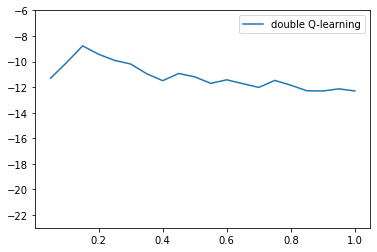

In [53]:
print('asymptotic')
R_mean = [np.mean(r) for r in rewards]
plt.plot(np.linspace(0.05, 1, 20), R_mean, label='double Q-learning')
plt.legend()
plt.ylim((-23, -6))

initial


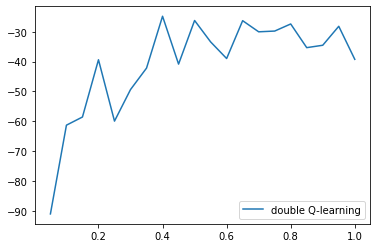

In [54]:
print('initial')
R_mean = [np.mean(r[:100]) for r in rewards]
plt.plot(np.linspace(0.05, 1, 20), R_mean, label='double Q-learning')
plt.legend()

In [5]:
rewards_eps = []

for eps in tqdm(np.linspace(0.05, 1, 20)):
    _, _, reward = double_q_learning(cliff, ϵ=eps, α=0.1, γ=1.0, num_episodes=100000, max_steps=1000)
    rewards_eps.append(reward)

/tmp/ipykernel_581/114021448.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eps in tqdm(np.linspace(0.05, 1, 20)):


  0%|          | 0/20 [00:00<?, ?it/s]

asymptotic


(-100.0, 0.0)

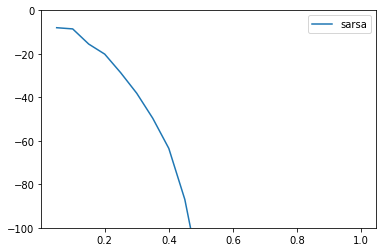

In [9]:
print('asymptotic')
R_mean = [np.mean(r) for r in rewards_eps]
plt.plot(np.linspace(0.05, 1, 20), R_mean, label='sarsa')
plt.legend()
plt.ylim((-100,0))

initial


(-100.0, 0.0)

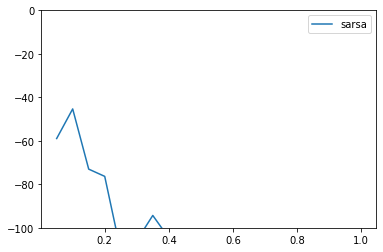

In [12]:
print('initial')
R_mean = [np.mean(r[:100]) for r in rewards_eps]
plt.plot(np.linspace(0.05, 1, 20), R_mean, label='sarsa')
plt.legend()
plt.ylim((-100,0))

initial


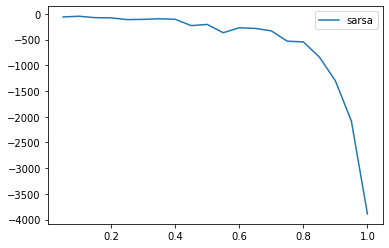

In [11]:
print('initial')
R_mean = [np.mean(r[:100]) for r in rewards_eps]
plt.plot(np.linspace(0.05, 1, 20), R_mean, label='sarsa')
plt.legend()
# plt.ylim((-100,0))